# Simulation of the $XY$ Transverse Field Ising Model with a Random $Z$ Field
We simulate the $XY$ transverse field Ising model with a random $Z$ field. We set `num_qubits=5`, `mean=0` and `std_deviation=3`. We start by importing necessary libraries etc.

In [1]:
# Importing necessary packages
# - `numpy` for numerical operations
# - `matplotlib` for plotting
# - `sys` for system-related functions
# - `time` for recording time
# - `qiskit` for quantum simulations

import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import import_ipynb
import qiskit
import scipy

from scipy.linalg import eig, expm

from qiskit.quantum_info import SparsePauliOp

### WARNING: COPY YOUR DIRECTORY'S PATH BELOW BEFORE RUNNING CODE ON YOUR LOCAL MACHINE  ###
sys.path.append("/Users/junaida/Documents/MPF-Cartan/")

We now initialize the model parameters and generate the KHK decomposition of the Hamiltonian. This is done by importing the functions defined in the notebook `Hamiltonian.ipynb`.

**Note:** If the `khk_decomposition` function from `Hamiltonian.ipynb` has already been executed and the data has been saved to a file, then the following cell should not be run.

In [2]:
from TFXY import Hamiltonian

# Mapping of integers to Pauli matrices: 0 = I, 1 = X, 2 = Y, 3 = Z
mapping = {0: 'I', 1: 'X', 2: 'Y', 3: 'Z'}

#CHANGE MODEL PARAMETERS HERE
mean = 0
std_deviation = 3
num_qubits = 5

#generate Hamiltonian for exact time evolution
tfxyH = Hamiltonian.gen_hamiltonian(num_qubits,mean,std_deviation)
length = len(tfxyH.HTuples)

operators = []

for i in range(length):
    
    map_to_string = np.vectorize(lambda x: mapping[x])
    operator_string = ''.join(map_to_string(tfxyH.HTuples[i]))
    operators.append(operator_string)
    
hamiltonian = SparsePauliOp(operators, tfxyH.HCoefs)

#Generate KHK decomposition
tfxyC, tfxyP = Hamiltonian.khk_decomposition(mean,std_deviation,num_qubits)

Optimization terminated successfully.
         Current function value: -0.187221
         Iterations: 236
         Function evaluations: 263
         Gradient evaluations: 263
--- 9.670802116394043 seconds ---
Optimization Error:
6.53357649714327e-10


## Results

We first import the functions in the notebooks `Generate_Circuit.ipynb` and `Model_Simulate.ipynb`

In [3]:
from Helper_Functions import Model_Simulate

We now attempt to replicate the results presented in Figure 4 of [arXiv:2104.00728](https://arxiv.org/pdf/2104.00728). We take the following steps:

* Intialize evolution time and time step size.
* We define the `observable`
$$
\hat{N} = \sum_{r=1}^{n} \frac{r - 1}{2}(I - Z_r)
$$
* We call the funtions in the `Model_Simulate` notebook.
* We compute $\bra{\psi_t} \hat{N}^2 \ket{\psi_t}$ and plot our findings.

In [4]:
#total evolution time and time step
evolution_time = 400
time_step = 0.5

#Trotter-Suzuki parameters
order=2
reps=4

# Define the operator hat_N
interactions = [("I", [0], num_qubits*(num_qubits-1)/4)]

for r in range(num_qubits):
    interactions.append(("Z", [r], -0.5*r))

hat_N = SparsePauliOp.from_sparse_list(interactions, num_qubits)
observable = hat_N @ hat_N

#Generate data
t_values = np.arange(time_step, evolution_time + time_step, time_step)

start = time.time()
ev_cartan, ev_trotter = Model_Simulate.model_simulate(tfxyP,evolution_time,time_step,num_qubits,mean,std_deviation,observable,hamiltonian,order,reps)
end = time.time()
print(end - start)

32.454155921936035


We now implement exact diagonalization

In [5]:
#Define the initial state
initial_state = np.zeros((2**num_qubits,1))
initial_state[1]=1
initial_state_conjugate = initial_state.conj().T

#Hamiltonain matrix
hamiltonian_matrix = hamiltonian.to_matrix()

#list to store expected values
ev_exact = list()

#we now compute expected values
observable_matrix = (hat_N@hat_N).to_matrix()

for t in t_values:
    
    hamiltonian_exp = expm(-1j*t*hamiltonian_matrix)
    ev = initial_state_conjugate@hamiltonian_exp.conj().T@observable_matrix@hamiltonian_exp@initial_state


    ev_exact.append(ev[0][0])

We now plot results

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


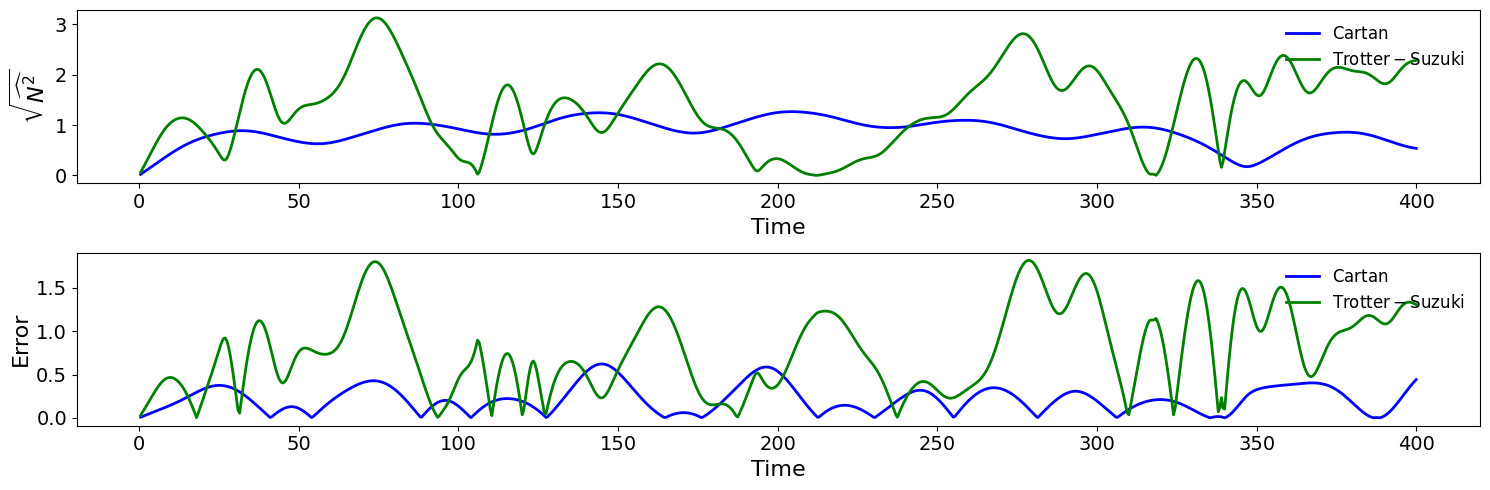

In [6]:
# Create the plot

#plt.style.use('default')
figure, axis = plt.subplots(2, 1, figsize=(15, 5))

# Plots
axis[0].plot(t_values, np.sqrt(ev_cartan), label=r'$\mathrm{Cartan}$',linewidth=2,color='blue')
axis[0].plot(t_values, np.sqrt(ev_trotter), label=r'$\mathrm{Trotter-Suzuki}$',linewidth=2,color='green')

axis[1].plot(t_values, np.abs(np.sqrt(np.real(ev_cartan))-np.sqrt(np.real(ev_exact))), label=r'$\mathrm{Cartan}$',linewidth=2,color='blue')
axis[1].plot(t_values, np.abs(np.sqrt(np.real(ev_trotter))-np.sqrt(np.real(ev_exact))), label=r'$\mathrm{Trotter-Suzuki}$',linewidth=2,color='green')

#Axes label
axis[0].set_xlabel(r'Time', fontsize=16)
axis[0].set_ylabel(r'$\sqrt{\widehat{N^2}}$', fontsize=16)

axis[1].set_xlabel(r'Time', fontsize=16)
axis[1].set_ylabel(r'Error', fontsize=16)

# Ensure y-range starts from 0
#plt.ylim(0, None)

# Add grid
#axis[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
#axis[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Legend
axis[0].legend(fontsize=12, loc='upper right', frameon=False, framealpha=0.9, edgecolor='black')
axis[1].legend(fontsize=12, loc='upper right', frameon=False, framealpha=0.9, edgecolor='black')

# Bold ticks
axis[0].tick_params(axis='x', labelsize=14)
axis[0].tick_params(axis='y', labelsize=14)

axis[1].tick_params(axis='x', labelsize=14)
axis[1].tick_params(axis='y', labelsize=14)

# Show the plot
plt.tight_layout()
plt.show()